In [1]:
import pickle
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections as col
from tqdm import tqdm

In [2]:
def compute_curve(sens, thresholds = np.arange(0.0,1.05, 0.05)):
    fracs = [0.0]
    for thresh in thresholds:
        frac = np.mean(sens >= thresh)
        fracs.append(frac)
    return pd.DataFrame({'Fraction of queries': fracs, 'Sensitivity to first FP': [1.0] + list(thresholds)})

In [3]:
def compute_sensitivity(sorted_labels, query_labels):
    ct_dict = col.Counter(query_labels)
    
    correct_counts = np.array([ct_dict[l] - 1 for l in query_labels])
    # print(correct_counts)
    # print(sorted_labels[:, :20])
    correct = sorted_labels == query_labels[:, np.newaxis]
    first_fp = np.argmin(correct, 1)
    sensitivity = first_fp / correct_counts
    return sensitivity

In [4]:
pdb_to_scop = {}
pdb_to_sfam = {}
pdb_to_fold = {}
with open('../mappings/dir.des.scope.2.01-stable.txt') as f:
    for line in f:
        if line[0] == '#':
            continue
        else:
            l = line.strip().split('\t')
            _, cat, cls, pdbcd, desc = l
            if cat == 'px':
                pdb_to_scop[pdbcd] = cls
                pdb_to_sfam[pdbcd] = '.'.join(cls.split('.')[:3])
                pdb_to_fold[pdbcd] = '.'.join(cls.split('.')[:2])

In [5]:
scop_counts = col.Counter(list(pdb_to_scop.values()))
scop_sf_counts = col.Counter(['.'.join(s.split('.')[:3]) for s in pdb_to_scop.values()])
scop_fold_counts = col.Counter(['.'.join(s.split('.')[:2]) for s in pdb_to_scop.values()])

In [6]:
tfidf_res = pd.read_csv(f'data/scop40_201_tfidf_50000_search_results.csv')
tfidf_res['scop_query'] = tfidf_res['query'].apply(lambda x: pdb_to_scop.get(x, '-.-.-.-'))
tfidf_res['scop_target'] = tfidf_res['target'].apply(lambda x: pdb_to_scop.get(x, '-.-.-.-'))
tfidf_res

,query,target,score,scop_query,scop_target
0,d12asa_,d12asa_,1.000000,d.104.1.1,d.104.1.1
1,d12asa_,d1b8aa2,0.172446,d.104.1.1,d.104.1.1
2,d12asa_,d1nnha_,0.167075,d.104.1.1,d.104.1.1
3,d12asa_,d1eova2,0.136321,d.104.1.1,d.104.1.1
4,d12asa_,d1e1oa2,0.125144,d.104.1.1,d.104.1.1
...,...,...,...,...,...
42884018,d1zzwa_,d3gvoa_,0.001757,c.45.1.0,a.118.1.8
42884019,d1zzwa_,d1u6gc_,0.001658,c.45.1.0,a.118.1.2
42884020,d1zzwa_,d1daba_,0.001600,c.45.1.0,b.80.1.7
42884021,d1zzwa_,d1jtdb_,0.001562,c.45.1.0,b.69.5.2


In [7]:
tfidf_res = tfidf_res[~(tfidf_res['query'] == tfidf_res['target'])]
tfidf_res = tfidf_res.drop_duplicates(['query', 'target'])

In [8]:
top1 = tfidf_res.groupby('query').nth(0)
correct_fam = np.mean(top1['scop_query'] == top1['scop_target'])
correct_sfam = np.mean(np.array(['.'.join(s.split('.')[:3]) for s in top1['scop_query']]) == np.array(['.'.join(s.split('.')[:3]) for s in top1['scop_target']]))
correct_fold = np.mean(np.array(['.'.join(s.split('.')[:2]) for s in top1['scop_query']]) == np.array(['.'.join(s.split('.')[:2]) for s in top1['scop_target']]))
print(f'Top1 accuracy (family): {correct_fam}')
print(f'Top1 accuracy (superfamily): {correct_sfam}')
print(f'Top1 accuracy (fold): {correct_fold}')

Top1 accuracy (family): 0.7000557103064067
Top1 accuracy (superfamily): 0.8729805013927576
Top1 accuracy (fold): 0.8924791086350975


In [9]:
tfidf_res['correct_fam'] = tfidf_res['scop_query'] == tfidf_res['scop_target']
tfidf_res['correct_sfam'] = np.array(['.'.join(s.split('.')[:3]) for s in tfidf_res['scop_query']]) == np.array(['.'.join(s.split('.')[:3]) for s in tfidf_res['scop_target']])
tfidf_res['correct_fold'] = np.array(['.'.join(s.split('.')[:2]) for s in tfidf_res['scop_query']]) == np.array(['.'.join(s.split('.')[:2]) for s in tfidf_res['scop_target']])

In [10]:
topk_results = []
for k in range(1,11):
    correct_fam = tfidf_res.groupby('query')['correct_fam'].head(k).mean()
    correct_sf = tfidf_res.groupby('query')['correct_sfam'].head(k).mean()
    correct_fold = tfidf_res.groupby('query')['correct_fold'].head(k).mean()
    topk_results.append([k, correct_fam, correct_sf, correct_fold])
collapse_topk = pd.DataFrame(topk_results, columns=['k', 'family', 'superfamily', 'fold'])

In [11]:
collapse_topk

,k,family,superfamily,fold
0,1,0.700056,0.872981,0.892479
1,2,0.622228,0.819387,0.846462
2,3,0.567539,0.776787,0.808877
3,4,0.524708,0.742117,0.778329
4,5,0.490563,0.712624,0.752000
5,6,0.462284,0.688171,0.730399
6,7,0.438880,0.667362,0.712380
7,8,0.418900,0.648744,0.695673
8,9,0.401303,0.631735,0.680077
9,10,0.385540,0.616510,0.666485


In [12]:
foldseek_results = pd.read_csv('/scratch/users/aderry/foldseek/results/rawoutput/foldseekaln201', sep='\t', header=None, names='query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits'.split(','))
foldseek_results['query'] = foldseek_results['query'].str.split('.', expand=True).iloc[:, 0]
foldseek_results['scop_query'] = foldseek_results['query'].apply(lambda x: pdb_to_scop.get(x, '-.-.-.-'))
foldseek_results['target'] = foldseek_results['target'].str.split('.', expand=True).iloc[:, 0]
foldseek_results['scop_target'] = foldseek_results['target'].apply(lambda x: pdb_to_scop.get(x, '-.-.-.-'))
foldseek_results.head()

,query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,scop_query,scop_target
0,d2vmha_,d2vmha_,1.000,147,0,0,1,147,1,147,1.098000e-29,1343,b.18.1.33,b.18.1.33
1,d2vmha_,d2vnga1,0.260,166,107,0,2,147,1,166,2.230000e-11,550,b.18.1.33,b.18.1.33
2,d2vmha_,d1od3a_,0.129,145,105,0,3,147,9,129,2.588000e-04,244,b.18.1.33,b.18.1.10
3,d2vmha_,d1v0aa1,0.142,148,117,0,10,146,14,161,1.345000e-03,213,b.18.1.33,b.18.1.30
4,d2vmha_,d2i74a1,0.094,133,112,0,14,146,49,173,1.577000e-03,210,b.18.1.33,b.18.1.29


In [13]:
foldseek_results = foldseek_results[~(foldseek_results['query'] == foldseek_results['target'])]
foldseek_results = foldseek_results.drop_duplicates(['query', 'target'])
foldseek_results.shape

(4239407, 14)

In [14]:
top1 = foldseek_results.groupby('query').nth(0)
correct_fam = np.mean(top1['scop_query'] == top1['scop_target'])
correct_sfam = np.mean(np.array(['.'.join(s.split('.')[:3]) for s in top1['scop_query']]) == np.array(['.'.join(s.split('.')[:3]) for s in top1['scop_target']]))
correct_fold = np.mean(np.array(['.'.join(s.split('.')[:2]) for s in top1['scop_query']]) == np.array(['.'.join(s.split('.')[:2]) for s in top1['scop_target']]))
print(f'Top1 accuracy (family): {correct_fam}')
print(f'Top1 accuracy (superfamily): {correct_sfam}')
print(f'Top1 accuracy (fold): {correct_fold}')

Top1 accuracy (family): 0.6467361985254451
Top1 accuracy (superfamily): 0.8761913324941557
Top1 accuracy (fold): 0.9057723431037583


In [15]:
foldseek_results['correct_fam'] = foldseek_results['scop_query'] == foldseek_results['scop_target']
foldseek_results['correct_sfam'] = np.array(['.'.join(s.split('.')[:3]) for s in foldseek_results['scop_query']]) == np.array(['.'.join(s.split('.')[:3]) for s in foldseek_results['scop_target']])
foldseek_results['correct_fold'] = np.array(['.'.join(s.split('.')[:2]) for s in foldseek_results['scop_query']]) == np.array(['.'.join(s.split('.')[:2]) for s in foldseek_results['scop_target']])

In [16]:
topk_results = []
for k in range(1,11):
    correct_fam = foldseek_results.groupby('query')['correct_fam'].head(k).mean()
    correct_sf = foldseek_results.groupby('query')['correct_sfam'].head(k).mean()
    correct_fold = foldseek_results.groupby('query')['correct_fold'].head(k).mean()
    topk_results.append([k, correct_fam, correct_sf, correct_fold])
foldseek_topk = pd.DataFrame(topk_results, columns=['k', 'family', 'superfamily', 'fold'])

In [17]:
foldseek_melted = foldseek_topk.melt('k', ['family', 'superfamily', 'fold'], var_name='level', value_name='precision')
collapse_melted = collapse_topk.melt('k', ['family', 'superfamily', 'fold'], var_name='level', value_name='precision')
combined_topk = pd.concat([foldseek_melted, collapse_melted])
combined_topk['method'] = ['Foldseek']*len(foldseek_melted) + ['COLLAPSE-cluster-TFIDF']*len(collapse_melted)

Text(0, 0.5, 'Top-k precision')

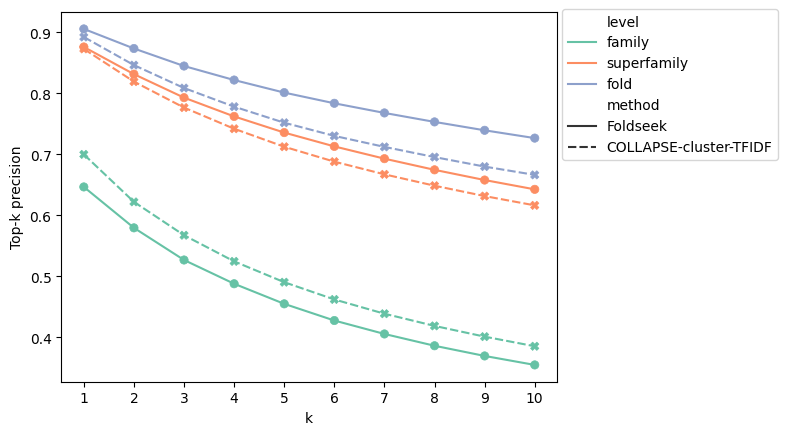

In [18]:
sns.lineplot(x='k', y='precision', hue='level', data=combined_topk, style='method', markers=False, palette='Set2')
sns.scatterplot(x='k', y='precision', hue='level', data=combined_topk, style='method', edgecolor=None, legend=False, palette='Set2')
plt.legend(loc=(1.01,0.6))
plt.xticks(np.arange(1,11))
plt.ylabel('Top-k precision')
# plt.savefig('figures/topk_precision.svg', dpi=300, bbox_inches='tight', format='svg')